In [22]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import time

from collections import Counter, defaultdict
from matplotlib import rcParams
from scipy.stats import spearmanr

%matplotlib inline

In [23]:
def separate_chunks(list_, n_per_chunk_):
    """Handle output from R"""
    for i in range(0, len(list_), n_per_chunk_):  
        yield list_[i:i + n_per_chunk_]
        

def docs_as_dists(topic_list_):
    """Represent each document as a distribution of topic probabilities"""
    topic_lengths = set(len(topic_) for topic_ in topic_list_)
    print(topic_lengths)
    assert len(topic_lengths) == 1
    response_vecs_ = []
    num_topics = len(topic_list_)
    topic_len = list(topic_lengths)[0]
    for i in range(topic_len):
        vec = []
        for j in range(num_topics):
            val = topic_list_[j][i]
            vec.append(val)
        response_vecs_.append(vec)
    return response_vecs_


def get_upper_bound(num_tests = 1, alpha = 0.05, one_tailed = False):
    """Helper function for implementing bootstrap percentile method"""
    lower = alpha/num_tests/2
    if one_tailed:
        lower *= 2
    return 1 - lower


def get_lower_bound(num_tests = 1, alpha = 0.05, one_tailed = False):
    """Helper function for implementing bootstrap percentile method"""
    lower = alpha/num_tests/2
    if one_tailed:
        lower *= 2
    return lower


def get_upper_index(upper_bound, distribution):
    """Find index based on upper bound and distribution size"""
    upper_idx = int(np.floor(upper_bound * len(distribution)))
    return upper_idx


def get_lower_index(lower_bound, distribution):
    """Find index based on lower bound and distribution size"""
    lower_idx = int(np.ceil(lower_bound * len(distribution)))
    return lower_idx


def hypothesis_testing_rho_distributions(real_ests, sim_ests_dict, alpha = 0.05, bonferroni = True, one_tailed = False):
    """Compare Spearman rank-order correlation coefficients to distribution of simulated coefficients
    using the bootstrap percentile method"""
    test_mat = np.zeros(real_ests.shape)
    num_tests = 1
    if bonferroni == True:
        num_tests = real_ests.size
    upper_bound = get_upper_bound(num_tests, alpha, one_tailed)
    lower_bound = get_lower_bound(num_tests, alpha, one_tailed)
    for i, row in enumerate(real_ests):
        for j, col in enumerate(row):
            rho_ij = real_ests[i][j]
            sims = sim_ests_dict[i][j] # in contrast to tjur R2 tests, comparing only to cell_ij
            sims = sorted(sims)
            upper_idx = get_upper_index(upper_bound, sims)
            lower_idx = get_lower_index(lower_bound, sims)
            test_stat_upper = sims[upper_idx]
            test_stat_lower = sims[lower_idx]
            if rho_ij > test_stat_upper:
                test_mat[i][j] = 1
            elif rho_ij < test_stat_lower:
                test_mat[i][j] = 1
    print(np.count_nonzero(test_mat)/test_mat.size)
    return test_mat


def results_to_strings(results, sig_tests):
    """Add asterisks to significant results (etc.)"""
    mat = []
    for i, row in enumerate(results):
        row_str = []
        for j, cell in enumerate(row):
            res = f"{cell:.3f}"
            if sig_tests[i][j]:
                res += "*"
            row_str.append(res)
        mat.append(row_str)
    return mat

In [3]:
topic_cols = [f"topic_{i}" for i in range(1,36)]

In [4]:
path_to_sims = "simulated_corpora/"

fs1 = [f for f in os.listdir(path_to_sims) if "ngrams_df_sim" in f]

fs2 = [f for f in os.listdir(path_to_sims) if "topicmodel_k15_sim" in f]
fs3 = [f for f in os.listdir(path_to_sims) if "topic_probs_k15_sim" in f]
fs4 = [f for f in os.listdir(path_to_sims) if "_lda15gamma" in f]
fs5 = [f for f in os.listdir(path_to_sims) if "_lda15beta" in f]
fs6 = [f for f in os.listdir(path_to_sims) if "likeliest_terms_k15" in f]

fs7 = [f for f in os.listdir(path_to_sims) if "topicmodel_k35_sim" in f]
fs8 = [f for f in os.listdir(path_to_sims) if "topic_probs_k35_sim" in f]
fs9 = [f for f in os.listdir(path_to_sims) if "_lda35gamma" in f]
fs10 = [f for f in os.listdir(path_to_sims) if "_lda35beta" in f]
fs11 = [f for f in os.listdir(path_to_sims) if "likeliest_terms_k35" in f]

In [5]:
fs = [fs1, fs2, fs3, fs4, fs5, fs6, fs7, fs8, fs9, fs10, fs11]

for f in fs:
    print(len(f))

1084
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [6]:
reg = "sim[0-9]{1,4}"

sim_nums = []

for i, f in enumerate(fs[1:]):
    f = [int(re.findall(reg, f_)[0].replace("sim", "")) for f_ in f]
    sim_nums += f

c = Counter(sim_nums)
for value in c.values():
    assert value == 10 # assert simulation number occurs only once in each file list
    
sim_nums = set(sim_nums)
print(len(sim_nums))
print(min(sim_nums))
print(max(sim_nums))

missing = [i for i in range(1,1085) if i not in sim_nums]
print(len(missing))

1000
1
1084
84


In [7]:
df_k15 = pd.read_csv("df_for_comparison_k15.csv")
df_k35 = pd.read_csv("df_for_comparison_k35.csv")

In [28]:
gamma_k15_real = pd.read_csv("lda15gamma.txt")
gamma_k15_real.drop(labels="Unnamed: 0", axis=1, inplace=True)

gamma_k35_real = pd.read_csv("lda35gamma.txt")
gamma_k35_real.drop(labels="Unnamed: 0", axis=1, inplace=True)

In [26]:
# df_k15.head()

In [10]:
# df_k35.head()

In [30]:
# gamma_k35_real.head()

In [12]:
df_k15 = df_k15[topic_cols[:15]]
df_k35 = df_k35[topic_cols[:35]]

row_sums_k15 = df_k15.sum(axis=1)
print(min(row_sums_k15), max(row_sums_k15))

row_sums_k35 = df_k35.sum(axis=1)
print(min(row_sums_k35), max(row_sums_k35))

0.9999998600000001 1.0000001400000003
0.9999998399999995 1.0000001600000001


In [13]:
gamma_k15_real.shape, gamma_k35_real.shape

((988, 15), (988, 35))

In [14]:
gamma_k15_real = gamma_k15_real
gamma_k35_real = gamma_k35_real

print(gamma_k15_real.shape, gamma_k35_real.shape)

row_sums_k15 = gamma_k15_real.sum(axis=1)
print(min(row_sums_k15), max(row_sums_k15))

row_sums_k35 = gamma_k35_real.sum(axis=1)
print(min(row_sums_k35), max(row_sums_k35))

(988, 15) (988, 35)
0.9999999999999987 1.0000000000000018
0.9999999999999981 1.000000000000002


In [15]:
start_time = time.time()

row_sums = set()

correlations_dict = defaultdict(lambda: defaultdict(lambda: []))

count = 0

for num in sorted(list(sim_nums)):
    
    count += 1
    
    f = f"{path_to_sims}sim{num}_lda15gamma.txt"
    lda15gamma = pd.read_csv(f)
    cols = [col for col in lda15gamma.columns if "Unnamed" not in col]
    lda15gamma = lda15gamma[cols].to_numpy()
    lda15gamma = np.flip(lda15gamma, axis=1)

    f = f"{path_to_sims}sim{num}_lda35gamma.txt"
    lda35gamma = pd.read_csv(f)
    cols = [col for col in lda35gamma.columns if "Unnamed" not in col]
    lda35gamma = lda35gamma[cols].to_numpy()
    
    assert lda15gamma.shape[0] == lda35gamma.shape[0] == 988
    assert lda15gamma.shape[1] == 15
    assert lda35gamma.shape[1] == 35
    
    sums_ = lda15gamma.sum(axis=1)
    sums_ = set([round(s, 5) for s in sums_])
    row_sums = row_sums.union(sums_)
    
    sums_ = lda35gamma.sum(axis=1)
    sums_ = set([round(s, 5) for s in sums_])
    row_sums = row_sums.union(sums_)
    
    correlations = np.zeros((lda15gamma.shape[1], lda35gamma.shape[1]))

    for i in range(15):
        topic_i = lda15gamma[:, i]
        assert topic_i.shape[0] == 988
        for j in range(35):
            topic_j = lda35gamma[:, j]
            assert topic_j.shape[0] == 988
            rho, pval = spearmanr(topic_i, topic_j)
            correlations[i][j] = rho
            correlations_dict[i][j].append(rho)

    if count % 100 == 0:
        print(count, f"{time.time() - start_time:.2f}")
        
correlations_dict2 = defaultdict(lambda: {})

for key_i in correlations_dict.keys():
    for key_j in correlations_dict[key_i].keys():
        corrs = correlations_dict[key_i][key_j]
        correlations_dict2[key_i][key_j] = corrs
        
correlations_dict2 = dict(correlations_dict2)

outf = "sim_doc_level_topic_correlations.d"
pickle.dump(correlations_dict2, open(outf, "wb"))

print(row_sums)

100 21.62
200 43.24
300 65.32
400 87.48
500 109.43
600 132.13
700 154.91
800 177.12
900 198.90
1000 220.63
{1.0}


In [16]:
infile = "sim_doc_level_topic_correlations.d"
correlations_dict2 = pickle.load(open(infile, "rb"))

In [17]:
len(correlations_dict2[0][0])

1000

In [18]:
# gamma_k15_real.head()

In [19]:
# gamma_k35_real.head()

In [20]:
real_correlations = np.zeros((15,35))

for i in range(15):
    topic_i = np.flip(gamma_k15_real.to_numpy(), axis=1)[:, i]
    assert topic_i.shape[0] == 988
    for j in range(35):
        topic_j = gamma_k35_real.to_numpy()[:, j]
        assert topic_j.shape[0] == 988
        rho, pval = spearmanr(topic_i, topic_j)
        real_correlations[i][j] = rho

## Figure 5. Spearman rank-order correlation coefficients between topic probabilities at the document level in the preferred (k = 15) and alternative (k = 35) models.

0.03619047619047619


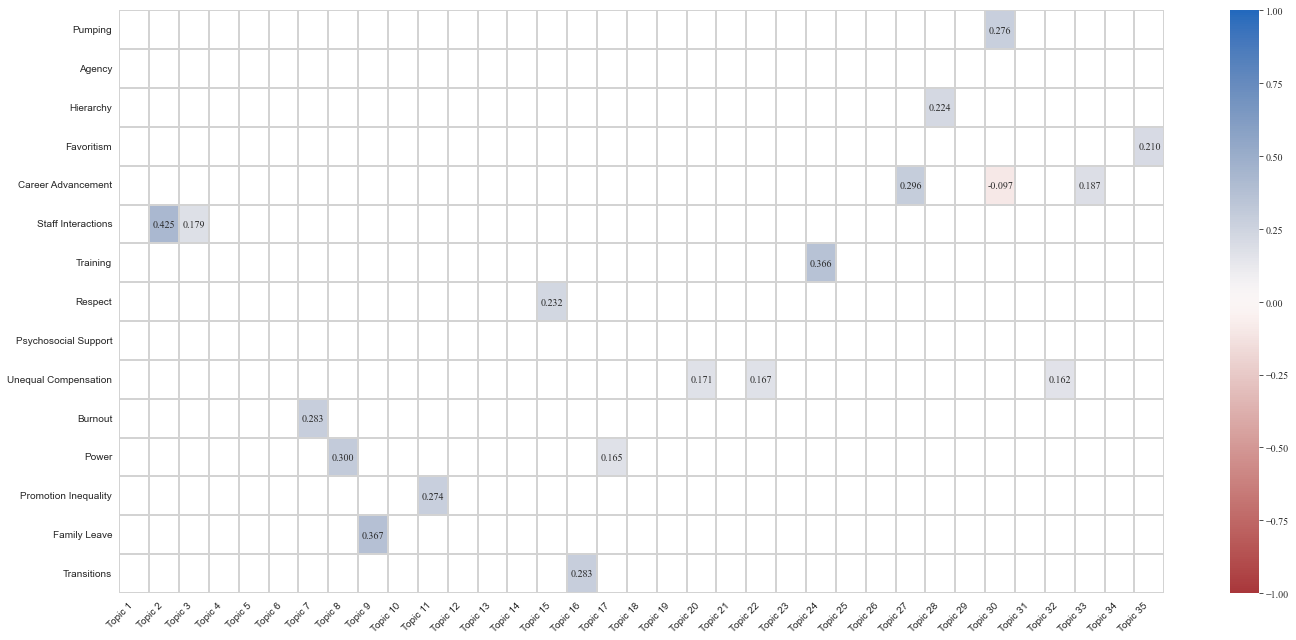

Figure 5. Spearman rank-order correlation coefficients between topic probabilities at the document level in the preferred (k = 15) and alternative (k = 35) models.


In [21]:
topic_labels = ["Transitions", "Family Leave", "Promotion Inequality", "Power", "Burnout", 
                "Unequal Compensation", "Psychosocial Support", "Respect", "Training", 
                "Staff Interactions", "Career Advancement", "Favoritism", "Hierarchy", "Agency", 
                "Pumping"]

f = "sim_doc_level_topic_correlations.d"
correlations_dict = pickle.load(open(f, "rb"))


topic_labels = copy.copy(topic_labels)
topic_labels.reverse()

alt_labels = [f"Topic {i}" for i in range(1,36)]

sig_tests = hypothesis_testing_rho_distributions(real_correlations, correlations_dict, 
                                         alpha = 0.05, bonferroni = True, one_tailed = False)
mat = results_to_strings(real_correlations, sig_tests)
df = pd.DataFrame(mat, columns=alt_labels)

outf = "model_comparison_table_doc_level.csv"
df.to_csv(outf)

mask = np.invert(sig_tests.astype(bool))

sns.set_style("white")

f, ax = plt.subplots(figsize=(20, 9))

cmap = sns.color_palette("vlag_r", n_colors=1000)
rcParams['figure.figsize'] = 16,9
rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['grid.linewidth'] = 2

plot = sns.heatmap(real_correlations, vmin=-1.0, vmax=1.0, center=0.0,
            square=False, linewidths=0.05,
            linecolor="lightgray",
            yticklabels=topic_labels,
            xticklabels=alt_labels,
            annot=True,
            fmt=".3f",
            cmap = cmap,
            mask = mask)

plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment="right")
plt.tight_layout()
for i in range(real_correlations.shape[1]+1):
    plt.axvline(x=i, color="lightgray")
for i in range(real_correlations.shape[0]+1):
    plt.axhline(y=i, color="lightgray")

plt.savefig("comparing_topic_models_qual_coding_figure5.png", format="png", transparent=False, dpi=600)
plt.show()

print("Figure 5. Spearman rank-order correlation coefficients between topic probabilities at the document level in the preferred (k = 15) and alternative (k = 35) models.")